In [7]:
import os
import glob
import pandas as pd

# -------------------------------------------------
# 1) 여러 인코딩 시도해서 CSV 읽기
# -------------------------------------------------
def read_csv_any(path, nrows=None):
    encodings = ["cp949", "utf-8-sig", "utf-8"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, nrows=nrows)
        except Exception as e:
            last_err = e
            continue
    print(f"[경고] {path} 읽기 실패. 마지막 에러: {last_err}")
    return None

# -------------------------------------------------
# 2) 현재 폴더의 CSV 파일들 목록 가져오기
# -------------------------------------------------
base_dir = os.getcwd()
print("현재 작업 폴더:", base_dir)

csv_files = sorted(glob.glob(os.path.join(base_dir, "*.csv")))
print("발견된 CSV 파일 수:", len(csv_files))
for f in csv_files:
    print(" -", os.path.basename(f))

# -------------------------------------------------
# 3) 각 CSV의 컬럼 구조를 요약해서 모으기
#    -> csv_구조요약.csv 로 저장
# -------------------------------------------------
summary_rows = []

for path in csv_files:
    fname = os.path.basename(path)
    print(f"\n=== {fname} 구조 분석 중 ===")

    # 파일 전체를 읽으면 너무 클 수 있으니 앞부분만 사용 (예: 200행)
    df = read_csv_any(path, nrows=200)
    if df is None:
        continue

    # 컬럼별로 타입 / non-null 개수 / 샘플 값 수집
    for col in df.columns:
        series = df[col]
        dtype = str(series.dtype)
        n_non_null = series.notna().sum()

        # 앞쪽에서 non-null 값 3개만 예시로 뽑기
        samples = series.dropna().astype(str).head(3).tolist()
        sample_str = " | ".join(samples)

        summary_rows.append({
            "파일명": fname,
            "컬럼명": col,
            "dtype": dtype,
            "non_null_개수(샘플200행 기준)": int(n_non_null),
            "예시값(최대3개)": sample_str
        })

# -------------------------------------------------
# 4) 요약 결과 저장
# -------------------------------------------------
summary_df = pd.DataFrame(summary_rows)

out_path = os.path.join(base_dir, "csv_구조요약.csv")
summary_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("\n=== 요약 완료 ===")
print("저장 위치:", out_path)


현재 작업 폴더: C:\Users\User\Desktop\csc 콘
발견된 CSV 파일 수: 5
 - 20251110_분야별_세출현황.csv
 - 국민기초생활수급자총괄_일반_시설_시도별_20251112031233.csv
 - 대기배출시설_단속_및_행정조치현황_20251112032044.csv
 - 장애유형_및_장애정도별_장애인_인구__시군구_20251112030846.csv
 - 행정구역_시도__연령별_경제활동인구_20251112025411.csv

=== 20251110_분야별_세출현황.csv 구조 분석 중 ===

=== 국민기초생활수급자총괄_일반_시설_시도별_20251112031233.csv 구조 분석 중 ===

=== 대기배출시설_단속_및_행정조치현황_20251112032044.csv 구조 분석 중 ===

=== 장애유형_및_장애정도별_장애인_인구__시군구_20251112030846.csv 구조 분석 중 ===

=== 행정구역_시도__연령별_경제활동인구_20251112025411.csv 구조 분석 중 ===

=== 요약 완료 ===
저장 위치: C:\Users\User\Desktop\csc 콘\csv_구조요약.csv


In [7]:
import os
import glob
import pandas as pd

# -------------------------------------------------
# 0) 기본 설정
# -------------------------------------------------
# 오염물질 폴더 이름들 (폴더 이름이 다르면 여기만 고치면 됨)
POLLUTANT_FOLDERS = ["PM-2.5", "PM-10", "아황산가스", "오존", "이산화질소", "일산화탄소"]

BASE_DIR = os.getcwd()  # 현재 작업 폴더
print("현재 작업 폴더:", BASE_DIR)

# -------------------------------------------------
# 1) 여러 인코딩 시도해서 CSV 읽기
# -------------------------------------------------
def read_csv_any(path, nrows=None):
    encodings = ["cp949", "utf-8-sig", "utf-8"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, nrows=nrows)
        except Exception as e:
            last_err = e
            continue
    print(f"[경고] {os.path.basename(path)} 읽기 실패 (CSV). 마지막 에러:", last_err)
    return None

# -------------------------------------------------
# 2) 구조 요약 정보 모을 리스트
# -------------------------------------------------
summary_rows = []

def add_df_summary(df, logical_name, file_type):
    """
    df: DataFrame
    logical_name: 파일/경로 이름(사용자가 알아보기 쉽게)
    file_type: 'csv' 또는 'excel'
    """
    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)
        n_non_null = int(s.notna().sum())
        samples = s.dropna().astype(str).head(3).tolist()
        sample_str = " | ".join(samples)
        summary_rows.append({
            "파일종류": file_type,
            "파일경로": logical_name,
            "컬럼명": col,
            "dtype": dtype,
            "non_null_개수(샘플행 기준)": n_non_null,
            "예시값(최대3개)": sample_str
        })

# -------------------------------------------------
# 3) 루트 폴더의 CSV 구조 요약
# -------------------------------------------------
csv_files = sorted(glob.glob(os.path.join(BASE_DIR, "*.csv")))
print("\n[루트 CSV 파일들]")
for path in csv_files:
    fname = os.path.basename(path)
    print(" -", fname)
    df = read_csv_any(path, nrows=200)  # 앞 200행만
    if df is None:
        continue
    add_df_summary(df, fname, "csv")

# -------------------------------------------------
# 4) 오염물질 폴더 안의 엑셀(xls/xlsx) 구조 요약
# -------------------------------------------------
print("\n[오염물질 폴더 엑셀 파일들]")

for folder in POLLUTANT_FOLDERS:
    folder_path = os.path.join(BASE_DIR, folder)
    if not os.path.isdir(folder_path):
        print(f" - 폴더 없음 (건너뜀): {folder}")
        continue

    # .xls, .xlsx 모두 찾기
    excel_paths = sorted(
        glob.glob(os.path.join(folder_path, "*.xls"))
        + glob.glob(os.path.join(folder_path, "*.xlsx"))
    )
    if not excel_paths:
        print(f" - {folder} 안에 엑셀 파일이 없음")
        continue

    print(f"\n[{folder}] 폴더 내 엑셀 파일 수: {len(excel_paths)}")

    for path in excel_paths:
        rel_name = os.path.relpath(path, BASE_DIR)  # 예: "PM-2.5/2024-9.xls"
        print("   >", rel_name)

        # 너가 보여준 스샷 기준으로 4번째 줄이 헤더라서 header=3 로 가정
        # (다르면 나중에 이 값만 바꾸면 됨)
        try:
            df = pd.read_excel(path, header=3, nrows=50)
        except Exception as e:
            print(f"   [경고] {rel_name} 읽기 실패 (Excel):", e)
            continue

        add_df_summary(df, rel_name, "excel")

# -------------------------------------------------
# 5) 요약 결과를 CSV로 저장
# -------------------------------------------------
summary_df = pd.DataFrame(summary_rows)

out_path = os.path.join(BASE_DIR, "데이터_구조요약.csv")
summary_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("\n=== 구조 요약 완료 ===")
print("저장된 파일:", out_path)


현재 작업 폴더: C:\Users\User\Desktop\csc 콘

[루트 CSV 파일들]
 - 20251110_분야별_세출현황.csv
 - 국민기초생활수급자총괄_일반_시설_시도별_20251112031233.csv
 - 대기배출시설_단속_및_행정조치현황_20251112032044.csv
 - 데이터_구조요약.csv
 - 장애유형_및_장애정도별_장애인_인구__시군구_20251112030846.csv
 - 행정구역_시도__연령별_경제활동인구_20251112025411.csv

[오염물질 폴더 엑셀 파일들]

[PM-2.5] 폴더 내 엑셀 파일 수: 12
   > PM-2.5\2024-10.xls
   > PM-2.5\2024-11.xls
   > PM-2.5\2024-12.xls
   > PM-2.5\2024-9.xls
   > PM-2.5\2025-1.xls
   > PM-2.5\2025-2.xls
   > PM-2.5\2025-3.xls
   > PM-2.5\2025-4.xls
   > PM-2.5\2025-5.xls
   > PM-2.5\2025-6.xls
   > PM-2.5\2025-7.xls
   > PM-2.5\2025-8.xls

[PM-10] 폴더 내 엑셀 파일 수: 12
   > PM-10\2024-10.xls
   > PM-10\2024-11.xls
   > PM-10\2024-12.xls
   > PM-10\2024-9.xls
   > PM-10\2025-1.xls
   > PM-10\2025-2.xls
   > PM-10\2025-3.xls
   > PM-10\2025-4.xls
   > PM-10\2025-5.xls
   > PM-10\2025-6.xls
   > PM-10\2025-7.xls
   > PM-10\2025-8.xls

[아황산가스] 폴더 내 엑셀 파일 수: 12
   > 아황산가스\2024-10.xls
   > 아황산가스\2024-11.xls
   > 아황산가스\2024-12.xls
   > 아황산가스\2024-9.xls

,지역,E_index,S_index,G_index,Risk_index,PM25_연평균,PM25_나쁨일수비율
13,경북,54.699496,67.859190,35.935285,61.836418,16.104110,0.038356
9,충북,66.575719,51.746511,34.928916,60.343109,17.106849,0.068493
0,서울,73.706902,41.339989,33.726774,59.273402,18.449315,0.090411
8,강원,30.317592,77.653103,25.263158,58.135646,13.649315,0.021918
11,전북,44.605012,65.510241,29.794898,58.087122,16.312329,0.032877
3,인천,85.354426,44.136057,71.421184,57.511957,19.224658,0.090411
10,충남,68.993285,48.992812,55.676923,56.059054,17.525281,0.057534
6,울산,43.849655,41.734595,16.124354,51.008829,15.797260,0.030137
12,전남,19.281390,75.171418,35.168014,50.747521,12.536986,0.005479
1,부산,27.109485,72.993840,67.715481,46.498234,14.216438,0.021918


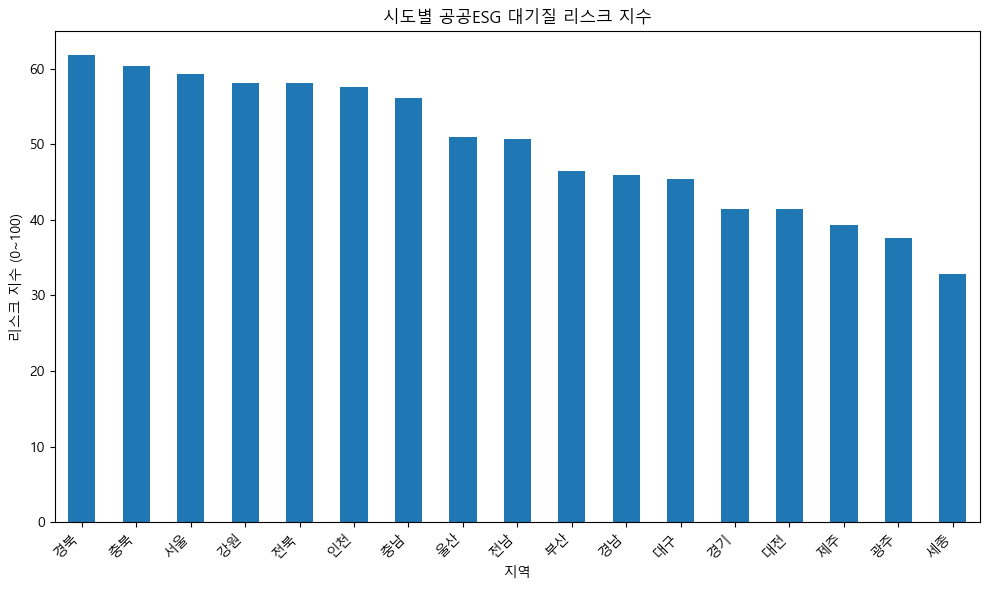

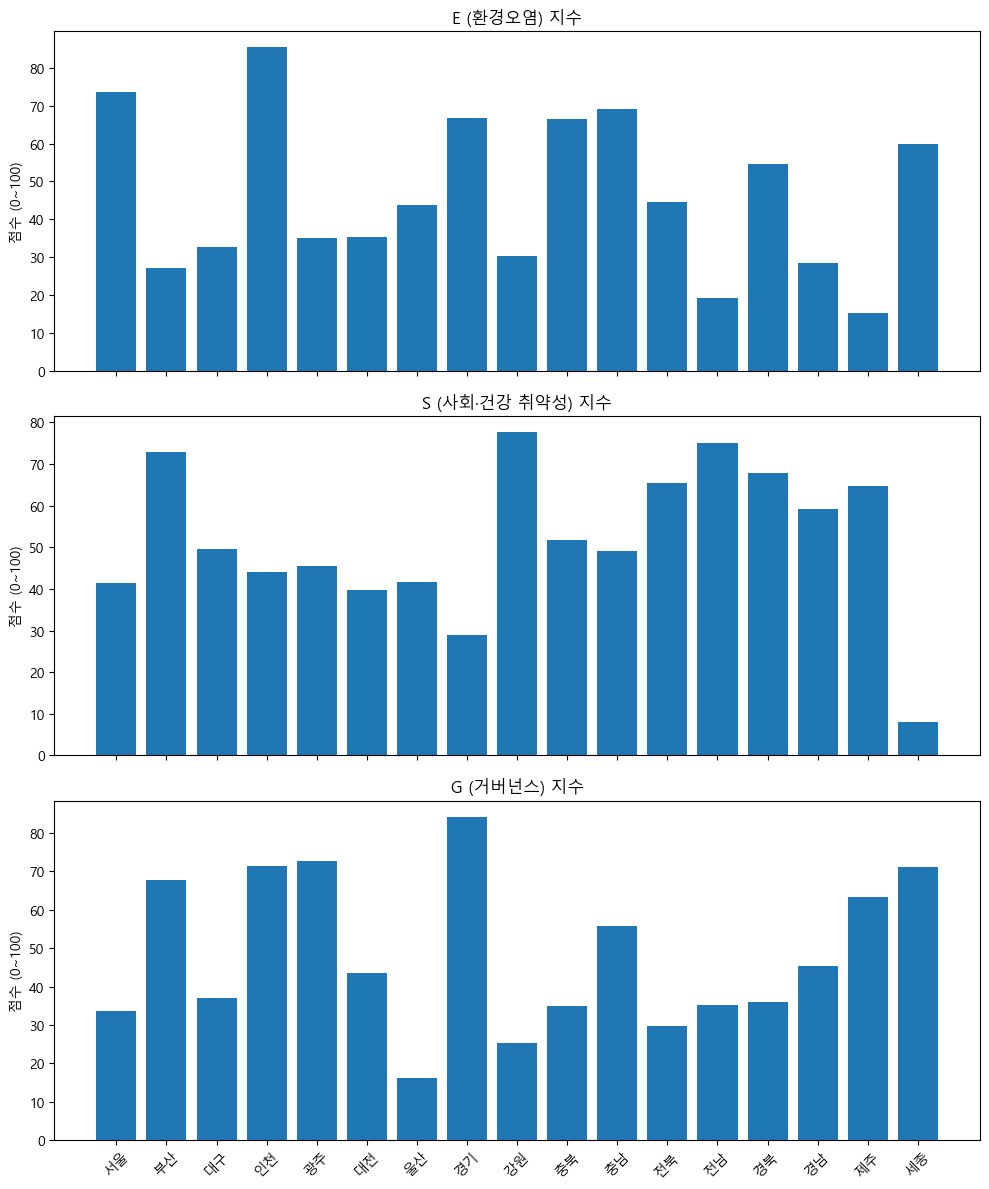

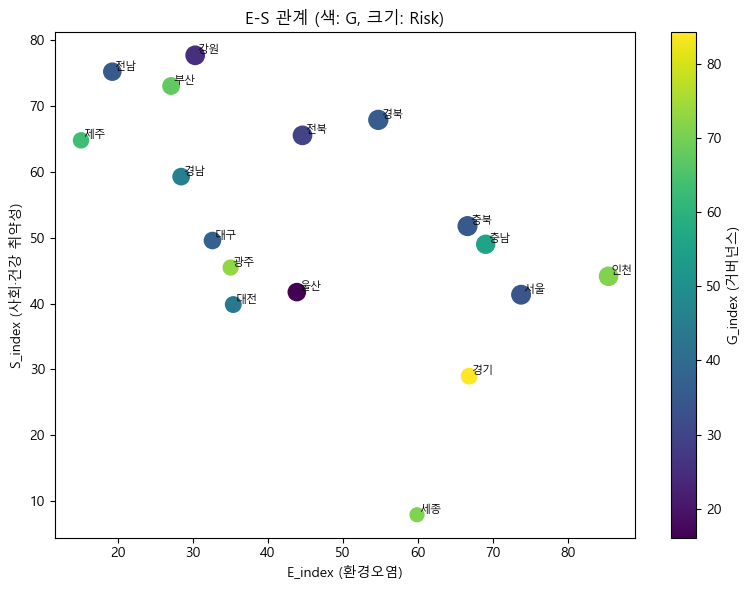

In [8]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# 0. 기본 설정
# =========================================
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

BASE_DIR = os.getcwd()

REGIONS = ["서울","부산","대구","인천","광주","대전","울산",
           "경기","강원","충북","충남","전북","전남","경북","경남","제주","세종"]

SIDO_MAP = {
    "서울특별시": "서울",
    "부산광역시": "부산",
    "대구광역시": "대구",
    "인천광역시": "인천",
    "광주광역시": "광주",
    "대전광역시": "대전",
    "울산광역시": "울산",
    "경기도": "경기",
    "강원도": "강원",
    "강원특별자치도": "강원",
    "충청북도": "충북",
    "충청남도": "충남",
    "전북특별자치도": "전북",
    "전라북도": "전북",
    "전라남도": "전남",
    "경상북도": "경북",
    "경상남도": "경남",
    "제주특별자치도": "제주",
    "세종특별자치시": "세종",
}

def to_short_region(x):
    """여러 형태의 시도 이름을 '서울','부산',... 같은 짧은 이름으로 통일"""
    if pd.isna(x):
        return None
    s = str(x).strip()

    # 1) 공식 긴 이름이 전체 문자열 어딘가에 포함되면 그걸로 매핑
    for long, short in SIDO_MAP.items():
        if long in s:
            return short

    # 2) 이미 짧은 이름(서울, 부산, 제주 등)이 들어 있으면 그대로 사용
    for short in REGIONS:
        if short in s:
            return short

    # 3) 그래도 안 걸리면 첫 단어 기준으로 기존 로직 사용
    first = s.split()[0]
    return SIDO_MAP.get(first, first)

def minmax_0_100(s: pd.Series):
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series(50.0, index=s.index)
    return (s - s.min()) / (s.max() - s.min()) * 100

def read_csv_any(path, nrows=None):
    for enc in ("cp949", "utf-8-sig", "utf-8"):
        try:
            return pd.read_csv(path, encoding=enc, nrows=nrows)
        except Exception:
            continue
    return pd.read_csv(path, nrows=nrows)


# =========================================
# 1. E - 대기오염 (PM / 가스 + 배출시설)
# =========================================
def load_pollutant_folder(folder_name: str):
    folder = os.path.join(BASE_DIR, folder_name)
    files = sorted(glob.glob(os.path.join(folder, "*.xls*")))
    dfs = []
    for f in files:
        # 에어코리아 형식: 4번째 줄에 '날짜, 서울, 부산, ...'
        df = pd.read_excel(f, header=3)
        if "날짜" not in df.columns:
            df.rename(columns={df.columns[0]: "날짜"}, inplace=True)
        keep = ["날짜"] + [c for c in df.columns if c in REGIONS]
        df = df[keep]
        dfs.append(df)
    all_df = pd.concat(dfs, ignore_index=True)
    all_df["날짜"] = pd.to_datetime(all_df["날짜"])
    return all_df

# 1-1. PM2.5 (핵심)
pm25 = load_pollutant_folder("PM-2.5")
pm25_mean = pm25[REGIONS].mean()
pm25_bad_ratio = (pm25[REGIONS] >= 35).sum() / len(pm25)

E_PM25_mean = minmax_0_100(pm25_mean)
E_PM25_bad  = minmax_0_100(pm25_bad_ratio)
E_PM25 = 0.5 * E_PM25_mean + 0.5 * E_PM25_bad

# 1-2. 나머지 5개 물질 (보완)
pm10 = load_pollutant_folder("PM-10")
so2  = load_pollutant_folder("아황산가스")
o3   = load_pollutant_folder("오존")
no2  = load_pollutant_folder("이산화질소")
co   = load_pollutant_folder("일산화탄소")

E_PM10 = minmax_0_100(pm10[REGIONS].mean())
E_SO2  = minmax_0_100(so2[REGIONS].mean())
E_O3   = minmax_0_100(o3[REGIONS].mean())
E_NO2  = minmax_0_100(no2[REGIONS].mean())
E_CO   = minmax_0_100(co[REGIONS].mean())

E_multi = (E_PM10 + E_SO2 + E_O3 + E_NO2 + E_CO) / 5

# 1-3. 대기배출시설 CSV (E 구조 + G 관리에 같이 사용)
fac = read_csv_any("대기배출시설_단속_및_행정조치현황_20251112032044.csv")

# 첫 두 행은 설명행 (단속사항 / 처분내용) → 제거
fac = fac.iloc[2:].reset_index(drop=True)

fac_lvl_col = fac.columns[0]   # '구분(1)'
fac_name_col = fac.columns[1]  # '구분(2)'

# 연도형 컬럼들: '2001', '2001.1', '2001.2' ...
year_cols = [c for c in fac.columns if str(c).split('.')[0].isdigit() and len(str(c).split('.')[0]) == 4]

# 연도 그룹핑해서 가장 최근 연도 선택
year_base = {}
for c in year_cols:
    y = int(str(c).split('.')[0])
    year_base.setdefault(y, []).append(c)

latest_year = max(year_base.keys())
# latest_year 그룹에서 .0(또는 suffix 없는) → 단속업소, .3 → 처분내용 계
fac_col = str(latest_year)          # 단속업소 (개소)
action_total_col = f"{latest_year}.3"  # 처분내용 계 (개소)

num_cols = year_base[latest_year]
fac[num_cols] = fac[num_cols].apply(
    lambda s: pd.to_numeric(
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("-", "0", regex=False),
        errors="coerce"
    )
)

# 시도 행만 추출
fac_sido = fac[fac[fac_lvl_col].astype(str).str.strip() == "시도"].copy()
fac_sido["region_full"] = fac_sido[fac_name_col].astype(str).str.strip()
fac_sido["region"] = fac_sido["region_full"].map(to_short_region)

facility_cnt = fac_sido.set_index("region")[fac_col]           # 단속업소 수
action_cnt   = fac_sido.set_index("region")[action_total_col]  # 행정조치 계


# =========================================
# 2. S - 사회·건강 취약성
# =========================================
# 2-1. 연령 구조 (고령 인구 비율)
age = read_csv_any("행정구역_시도__연령별_경제활동인구_20251112025411.csv")
# 헤더 행 제거
age = age[age["시도별"] != "시도별"].copy()

# 2024년 4/4 분기의 15세 이상 인구 기준 사용
pop_col = "2024.4/4"

# 문자열 → 숫자
age[pop_col] = pd.to_numeric(age[pop_col], errors="coerce")

age["region"] = age["시도별"].map(to_short_region)

# 전체(계), 60세이상
age_total = age[age["연령계층별"].astype(str).str.strip() == "계"].set_index("region")[pop_col]
age_old   = age[age["연령계층별"].astype(str).str.contains("60세이상")].set_index("region")[pop_col]

pop_total = age_total
pop_old   = age_old

age_ratio = (pop_old / pop_total)  # 고령비율만 사용 (0~14 데이터가 없어서)
S_age = minmax_0_100(age_ratio)

# 2-2. 장애인 (호흡기 장애 비율)
dis = read_csv_any("장애유형_및_장애정도별_장애인_인구__시군구_20251112030846.csv")
# 헤더행 제거
dis = dis[dis["행정구역별(시군구)"] != "행정구역별(시군구)"].copy()

dis["region"] = dis["행정구역별(시군구)"].map(to_short_region)
dis["2024"] = pd.to_numeric(
    dis["2024"].astype(str).str.replace(",", "", regex=False).str.replace("X", "0", regex=False),
    errors="coerce"
)

resp = dis[dis["장애유형별"].astype(str).str.contains("호흡")].copy()
resp_by_region = resp.groupby("region")["2024"].sum()

resp_dis_ratio = (resp_by_region / pop_total)
S_dis = minmax_0_100(resp_dis_ratio)

# 2-3. 기초생활수급자 비율
bmi = read_csv_any("국민기초생활수급자총괄_일반_시설_시도별_20251112031233.csv")
# 헤더행 제거
bmi = bmi[bmi["행정구역별"] != "행정구역별"].copy()

bmi["region"] = bmi["행정구역별"].map(to_short_region)
bmi["2024"] = pd.to_numeric(
    bmi["2024"].astype(str).str.replace(",", "", regex=False),
    errors="coerce"
)
bmi_total = bmi.set_index("region")["2024"]

bmi_ratio = bmi_total / pop_total
S_pov = minmax_0_100(bmi_ratio)

# 2-4. 호흡기 질환 (지금은 파일 없다고 보고 50점 고정)
S_disease = pd.Series(50.0, index=REGIONS)

# 2-5. 최종 S지수 (공식 그대로)
S_index = (
    0.4  * S_age.reindex(REGIONS) +
    0.25 * S_dis.reindex(REGIONS) +
    0.20 * S_pov.reindex(REGIONS) +
    0.15 * S_disease.reindex(REGIONS)
)


# =========================================
# 3. G - 거버넌스 (예산 + 관리)
# =========================================
# 3-1. 분야별 세출현황 (환경 예산 비중) - 환경만 있는 CSV 버전
bud = read_csv_any("20251110_분야별_세출현황.csv")

# '지역', '자치단체'가 위쪽에만 있고 아래는 NaN일 수 있으니 채워 넣기
bud["지역"] = bud["지역"].ffill()
bud["자치단체"] = bud["자치단체"].ffill()

# 자치단체가 ○○계 인 행만 사용 (전국계, 서울계, 부산계, ...)
bud_sido = bud[bud["자치단체"].astype(str).str.endswith("계")].copy()
bud_sido["region"] = bud_sido["지역"].astype(str).str.strip()

# 예산현액비중 컬럼 이름은 '예산현액비중' (공백 없음)
bud_sido["예산현액비중"] = pd.to_numeric(
    bud_sido["예산현액비중"].astype(str).str.replace(",", "", regex=False),
    errors="coerce"
)

# 이 값을 그대로 G_budget 지표로 사용 (환경 분야 예산 비중)
G_budget = minmax_0_100(
    bud_sido.set_index("region")["예산현액비중"].reindex(REGIONS)
)


# 3-2. 배출시설 단속·행정조치 강도
inspect_rate = (action_cnt / facility_cnt)  # 시설당 행정조치 수
G_reg = minmax_0_100(inspect_rate.reindex(REGIONS))

# 3-3. 최종 G지수
G_index = 0.6 * G_budget.reindex(REGIONS) + 0.4 * G_reg.reindex(REGIONS)


# =========================================
# 4. 최종 E, S, G, Risk 지수 계산
# =========================================
# E 구조: 인구 10만 명당 배출시설 수
fac_per100k = (facility_cnt / pop_total * 100000).reindex(REGIONS)
E_struct = minmax_0_100(fac_per100k)

E_index = (
    0.6  * E_PM25.reindex(REGIONS) +
    0.25 * E_multi.reindex(REGIONS) +
    0.15 * E_struct
)

Risk_index = (
    0.4 * E_index +
    0.4 * S_index +
    0.2 * (100 - G_index)
)

# 정리된 결과 테이블
summary = pd.DataFrame({
    "지역": REGIONS,
    "E_index": E_index.values,
    "S_index": S_index.values,
    "G_index": G_index.values,
    "Risk_index": Risk_index.values,
    "PM25_연평균": pm25_mean.reindex(REGIONS).values,
    "PM25_나쁨일수비율": pm25_bad_ratio.reindex(REGIONS).values
})

summary_sorted = summary.sort_values("Risk_index", ascending=False)
display(summary_sorted)


# =========================================
# 5. 시각화
# =========================================
# 5-1. 리스크 지수 막대그래프 (내림차순)
plt.figure(figsize=(10, 6))
summary_sorted.set_index("지역")["Risk_index"].plot(kind="bar")
plt.ylabel("리스크 지수 (0~100)")
plt.title("시도별 공공ESG 대기질 리스크 지수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 5-2. E / S / G 지수 비교 (세로 3개)
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for ax, col, title in zip(
    axes,
    ["E_index", "S_index", "G_index"],
    ["E (환경오염) 지수", "S (사회·건강 취약성) 지수", "G (거버넌스) 지수"]
):
    data = summary.set_index("지역")[col].reindex(REGIONS)
    ax.bar(data.index, data.values)
    ax.set_title(title)
    ax.set_ylabel("점수 (0~100)")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# 5-3. E vs S 산점도 (색=G, 크기=Risk)
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    summary["E_index"],
    summary["S_index"],
    c=summary["G_index"],
    s=summary["Risk_index"] * 3,
    cmap="viridis"
)
for _, row in summary.iterrows():
    plt.text(row["E_index"] + 0.3, row["S_index"] + 0.3, row["지역"], fontsize=8)

plt.xlabel("E_index (환경오염)")
plt.ylabel("S_index (사회·건강 취약성)")
plt.title("E-S 관계 (색: G, 크기: Risk)")
cbar = plt.colorbar(sc)
cbar.set_label("G_index (거버넌스)")
plt.tight_layout()
plt.show()


NaN이 있는 지역 (있으면 아래에 표시됨):


,지역,E_index,S_index,G_index,Risk_index


=== 군집별 평균 E/S/G/Risk ===


,E_index,S_index,G_index,Risk_index
cluster,,,,
0,73.7,46.6,48.9,58.3
1,29.0,55.3,55.0,42.7
2,63.3,18.5,77.7,37.2
3,38.6,65.6,28.5,56.0



=== 각 지역의 군집 배정 ===


,지역,E_index,S_index,G_index,Risk_index,cluster
0,서울,73.706902,41.339989,33.726774,59.273402,0
3,인천,85.354426,44.136057,71.421184,57.511957,0
10,충남,68.993285,48.992812,55.676923,56.059054,0
9,충북,66.575719,51.746511,34.928916,60.343109,0
1,부산,27.109485,72.993840,67.715481,46.498234,1
2,대구,32.617449,49.559112,37.030672,45.464490,1
4,광주,35.028557,45.460023,72.846825,37.626067,1
5,대전,35.386082,39.848508,43.482502,41.397336,1
14,경남,28.448955,59.251359,45.431178,45.993890,1
15,제주,15.119139,64.754746,63.437991,39.261956,1


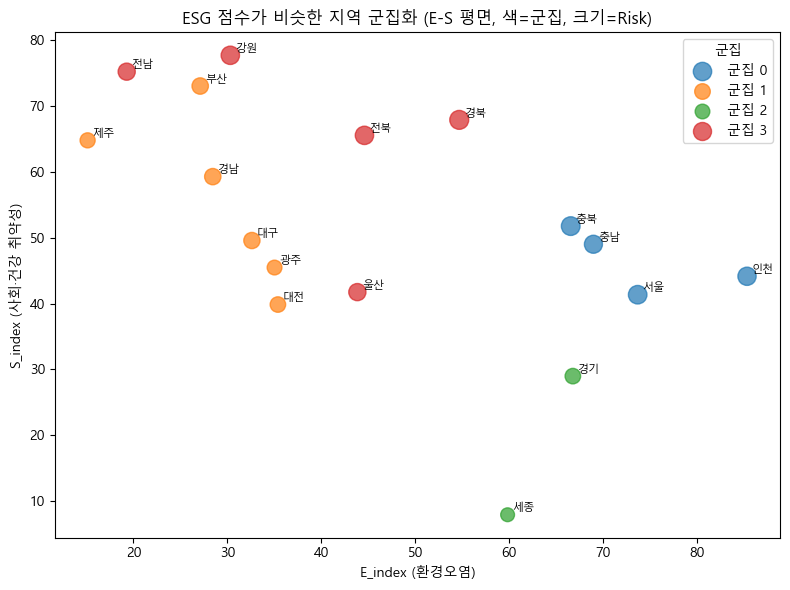

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# =========================================
# 6. ESG 점수 기반 군집화 (NaN 처리 포함)
# =========================================

features = ["E_index", "S_index", "G_index", "Risk_index"]

# 1) 원 데이터 확인
X_raw = summary[features].copy()

# NaN이 있는 지역 확인해보기 (참고용)
nan_rows = summary[summary[features].isna().any(axis=1)]
print("NaN이 있는 지역 (있으면 아래에 표시됨):")
display(nan_rows[["지역"] + features])

# 2) NaN을 각 열의 평균값으로 채우기
X_filled = X_raw.fillna(X_raw.mean())

# 3) 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

# 4) K-means 군집화
k = 4  # 군집 개수
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 5) summary에 군집 결과 추가
summary["cluster"] = clusters

# 6) 군집별 평균 ESG/Risk 요약
cluster_summary = summary.groupby("cluster")[["E_index", "S_index", "G_index", "Risk_index"]].mean().round(1)
print("=== 군집별 평균 E/S/G/Risk ===")
display(cluster_summary)

print("\n=== 각 지역의 군집 배정 ===")
display(summary[["지역","E_index","S_index","G_index","Risk_index","cluster"]].sort_values("cluster"))


# =========================================
# 7. 군집 시각화 (E-S 평면, 색=군집, 크기=Risk)
# =========================================
plt.figure(figsize=(8, 6))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

for cl in sorted(summary["cluster"].unique()):
    sub = summary[summary["cluster"] == cl]
    plt.scatter(
        sub["E_index"],
        sub["S_index"],
        s=sub["Risk_index"] * 3,  # 점 크기는 리스크 크기 비례
        c=colors[cl % len(colors)],
        alpha=0.7,
        label=f"군집 {cl}"
    )
    for _, row in sub.iterrows():
        plt.text(
            row["E_index"] + 0.5,
            row["S_index"] + 0.5,
            row["지역"],
            fontsize=8
        )

plt.xlabel("E_index (환경오염)")
plt.ylabel("S_index (사회·건강 취약성)")
plt.title("ESG 점수가 비슷한 지역 군집화 (E-S 평면, 색=군집, 크기=Risk)")
plt.legend(title="군집")
plt.tight_layout()
plt.show()


cluster
0    58.296880
1    42.706995
2    37.188533
3    55.963107
Name: base_mean_risk, dtype: float64

,cluster,axis,axis_name,intensity,mean_risk,delta_risk
0,0,E,E(환경),0,58.296880,7.105427e-15
1,0,E,E(환경),5,56.823729,-1.473152e+00
2,0,E,E(환경),10,55.350577,-2.946303e+00
3,0,E,E(환경),15,53.877425,-4.419455e+00
4,0,E,E(환경),20,52.404274,-5.892607e+00


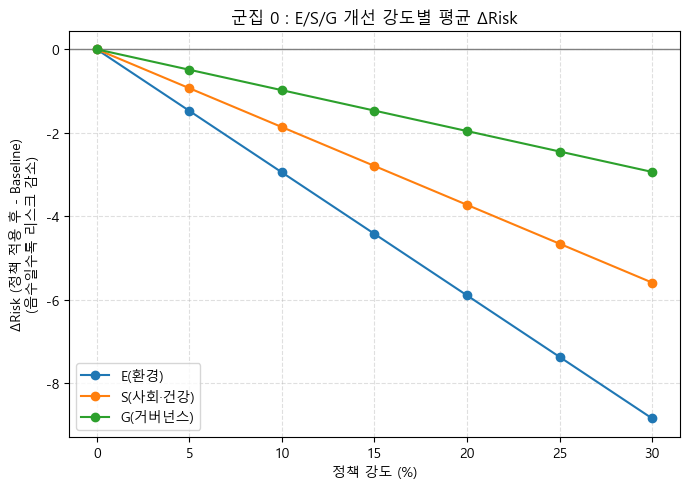

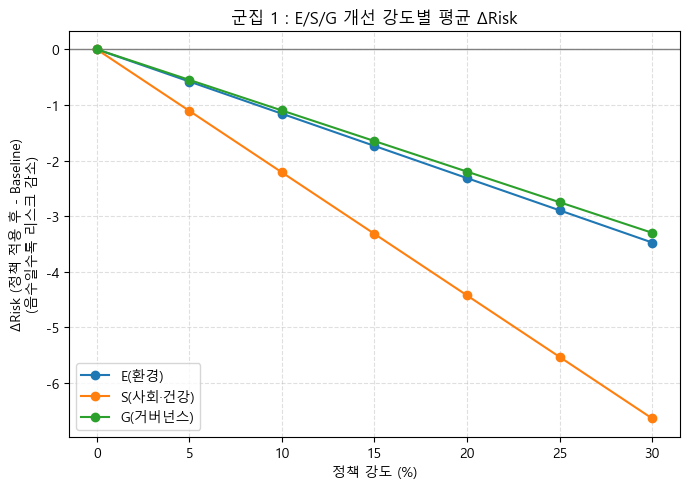

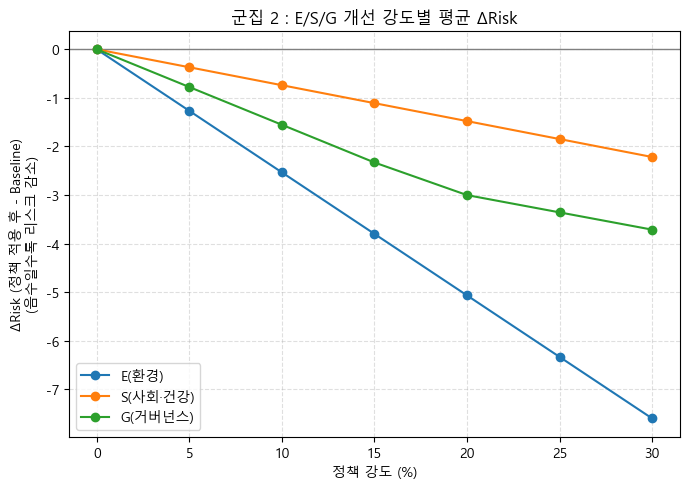

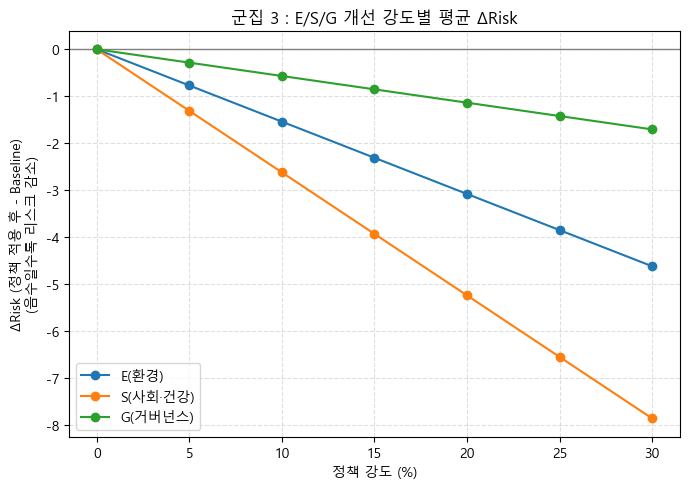

,cluster,best_axis,best_axis_name,best_intensity(%),base_mean_risk,best_mean_risk,delta_risk
0,0,E,E(환경),30,58.296880,49.457970,-8.838910
1,1,S,S(사회·건강),30,42.706995,36.069644,-6.637352
2,2,E,E(환경),30,37.188533,29.589329,-7.599204
3,3,S,S(사회·건강),30,55.963107,48.092822,-7.870285


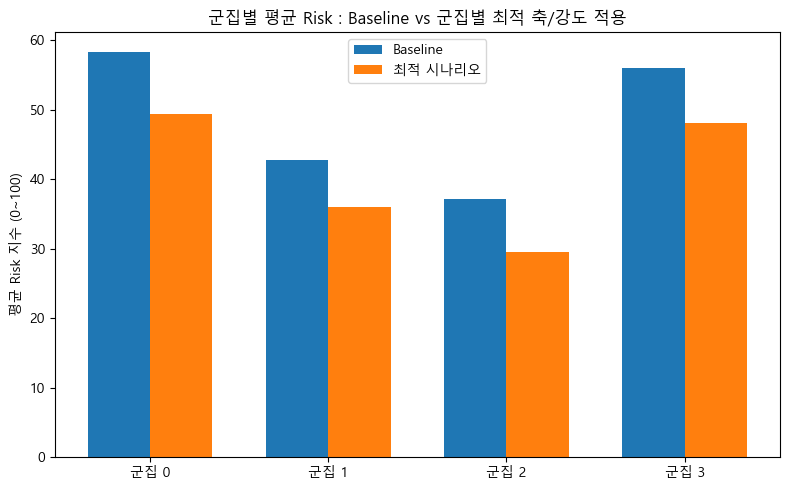

,cluster,base_mean_risk,opt_mean_risk,ΔRisk
0,0,58.296880,49.457970,-8.838910
1,1,42.706995,36.069644,-6.637352
2,2,37.188533,29.589329,-7.599204
3,3,55.963107,48.092822,-7.870285


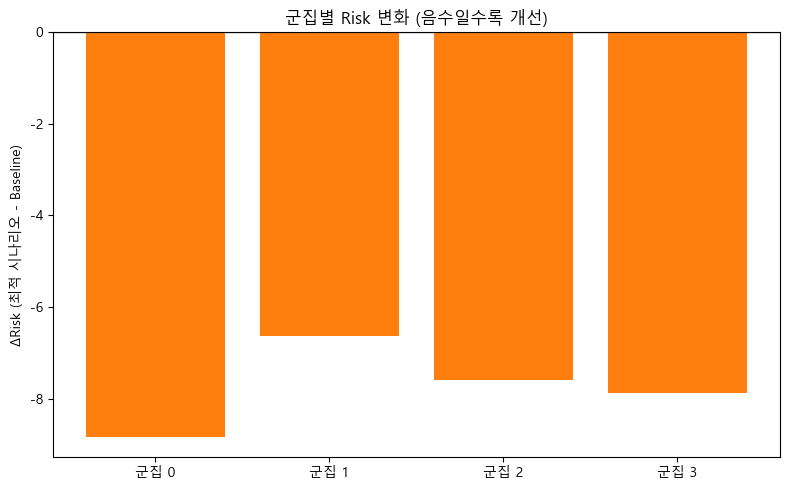

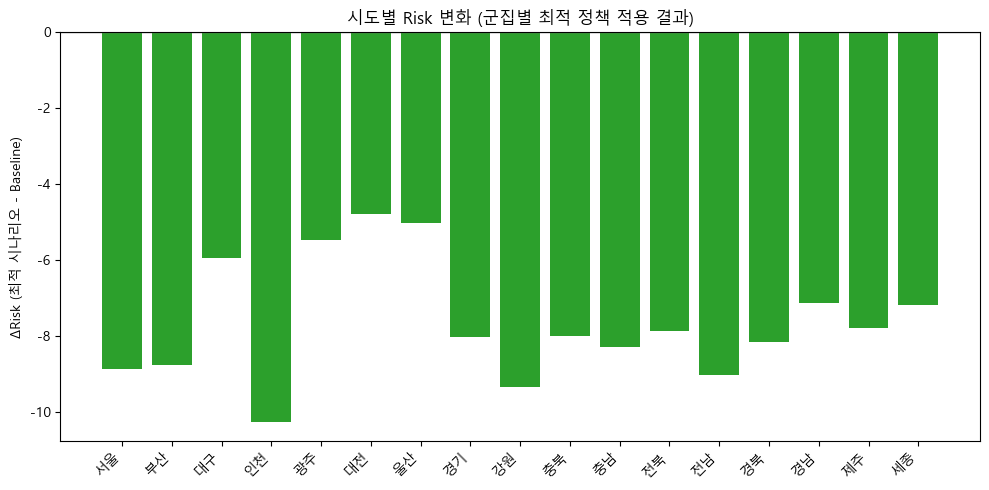

,지역,cluster,Risk_base,Risk_opt,ΔRisk
0,서울,0,59.273402,50.428573,-8.844828
1,부산,1,46.498234,37.738973,-8.759261
2,대구,1,45.464490,39.517397,-5.947093
3,인천,0,57.511957,47.269425,-10.242531
4,광주,1,37.626067,32.170864,-5.455203
5,대전,1,41.397336,36.615515,-4.781821
6,울산,3,51.008829,46.000678,-5.008151
7,경기,2,41.474691,33.458519,-8.016172
8,강원,3,58.135646,48.817274,-9.318372
9,충북,0,60.343109,52.354023,-7.989086


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 한글 깨짐 방지 (이미 위에서 했으면 생략 가능)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# -----------------------------------------
# 1. 데이터 준비
# -----------------------------------------
df = summary.copy()

if "cluster" not in df.columns:
    raise ValueError("먼저 군집화를 수행해서 summary['cluster'] 컬럼을 만들어 주세요.")

# 군집 번호 정렬
clusters = sorted(df["cluster"].unique())

# 군집별 baseline 평균 Risk
baseline_mean_risk = (
    df.groupby("cluster")["Risk_index"]
    .mean()
    .rename("base_mean_risk")
)

display(baseline_mean_risk)


# -----------------------------------------
# 2. 단일 정책 레버 (E / S / G) 적용 함수
#    - 한 군집에만 동일 강도로 적용
# -----------------------------------------
def apply_single_axis_policy(df, target_cluster, axis, intensity):
    """
    axis:
      - 'E' : E_index만 intensity% 감소 (환경 개선)
      - 'S' : S_index만 intensity% 감소 (사회·건강 취약성 완화)
      - 'G' : G_index만 intensity% 증가 (거버넌스 강화)
    intensity: 0, 5, 10, ... (퍼센트 단위)

    반환: (군집 평균 Risk_new)
    """
    out = df.copy()
    mask = (out["cluster"] == target_cluster)

    # 새 지수 초기값 = 기존 값 복사
    out["E_new"] = out["E_index"]
    out["S_new"] = out["S_index"]
    out["G_new"] = out["G_index"]

    # 축별 정책 적용
    if axis == "E":
        out.loc[mask, "E_new"] *= (1 - intensity / 100.0)
    elif axis == "S":
        out.loc[mask, "S_new"] *= (1 - intensity / 100.0)
    elif axis == "G":
        out.loc[mask, "G_new"] *= (1 + intensity / 100.0)
    else:
        raise ValueError("axis는 'E', 'S', 'G' 중 하나여야 합니다.")

    # G는 0~100 사이로 유지
    out["G_new"] = out["G_new"].clip(0, 100)

    # Risk 공식 그대로 사용
    out["Risk_new"] = (
        0.4 * out["E_new"]
        + 0.4 * out["S_new"]
        + 0.2 * (100 - out["G_new"])
    )

    # 타깃 군집의 평균 Risk 반환
    return out.loc[mask, "Risk_new"].mean()


# -----------------------------------------
# 3. E/S/G 각각 0~30% 개선 시나리오 스윕
#    → 군집별 민감도 테이블 만들기
# -----------------------------------------
intensities = [0, 5, 10, 15, 20, 25, 30]
axes = ["E", "S", "G"]
axis_kor = {"E": "E(환경)", "S": "S(사회·건강)", "G": "G(거버넌스)"}

rows = []

for c in clusters:
    base_mean = baseline_mean_risk.loc[c]
    for axis in axes:
        for k in intensities:
            mean_risk_new = apply_single_axis_policy(df, c, axis, k)
            rows.append({
                "cluster": c,
                "axis": axis,
                "axis_name": axis_kor[axis],
                "intensity": k,
                "mean_risk": mean_risk_new,
                "delta_risk": mean_risk_new - base_mean   # (음수일수록 리스크 감소)
            })

sens = pd.DataFrame(rows)
display(sens.head())


# -----------------------------------------
# 4. 각 군집마다 꺾은선 그래프
#    x축: 정책 강도 (%)
#    y축: ΔRisk (음수면 개선)
# -----------------------------------------
for c in clusters:
    sub = sens[sens["cluster"] == c]

    plt.figure(figsize=(7, 5))
    plt.axhline(0, color="gray", linewidth=1)

    for axis in axes:
        sub_a = sub[sub["axis"] == axis]
        plt.plot(
            sub_a["intensity"],
            sub_a["delta_risk"],
            marker="o",
            label=axis_kor[axis]
        )

    plt.title(f"군집 {c} : E/S/G 개선 강도별 평균 ΔRisk")
    plt.xlabel("정책 강도 (%)")
    plt.ylabel("ΔRisk (정책 적용 후 - Baseline)\n(음수일수록 리스크 감소)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


# -----------------------------------------
# 5. 각 군집별 '최적 축 + 강도' 찾기
#    → mean_risk 최소인 조합
# -----------------------------------------
best_rows = []

for c in clusters:
    sub = sens[(sens["cluster"] == c) & (sens["intensity"] > 0)]  # 0%는 '아무것도 안함'이라 제외
    idx_best = sub["mean_risk"].idxmin()
    best = sub.loc[idx_best]

    best_rows.append({
        "cluster": c,
        "best_axis": best["axis"],
        "best_axis_name": best["axis_name"],
        "best_intensity(%)": best["intensity"],
        "base_mean_risk": baseline_mean_risk.loc[c],
        "best_mean_risk": best["mean_risk"],
        "delta_risk": best["delta_risk"],    # 음수일수록 많이 줄어든 것
    })

best_table = pd.DataFrame(best_rows)
display(best_table)


# -----------------------------------------
# 6. '최적 축+강도'를 실제로 군집에 적용한 시나리오 생성
# -----------------------------------------
df_opt = df.copy()

# 새 지수 = 기존 지수 복사
df_opt["E_index_opt"] = df["E_index"]
df_opt["S_index_opt"] = df["S_index"]
df_opt["G_index_opt"] = df["G_index"]

# 군집별 최적 정책을 적용
for _, row in best_table.iterrows():
    c = row["cluster"]
    axis = row["best_axis"]
    inten = row["best_intensity(%)"]

    mask = (df_opt["cluster"] == c)

    if axis == "E":
        df_opt.loc[mask, "E_index_opt"] *= (1 - inten / 100.0)
    elif axis == "S":
        df_opt.loc[mask, "S_index_opt"] *= (1 - inten / 100.0)
    elif axis == "G":
        df_opt.loc[mask, "G_index_opt"] *= (1 + inten / 100.0)

# G는 0~100으로 제한
df_opt["G_index_opt"] = df_opt["G_index_opt"].clip(0, 100)

# 새 Risk 계산
df_opt["Risk_index_opt"] = (
    0.4 * df_opt["E_index_opt"]
    + 0.4 * df_opt["S_index_opt"]
    + 0.2 * (100 - df_opt["G_index_opt"])
)


# -----------------------------------------
# 7. 군집별 평균 Risk : Baseline vs 최적 정책 비교
# -----------------------------------------
base_means = df.groupby("cluster")[["E_index", "S_index", "G_index", "Risk_index"]].mean()
opt_means  = df_opt.groupby("cluster")[["E_index_opt", "S_index_opt", "G_index_opt", "Risk_index_opt"]].mean()

# (1) 군집별 평균 Risk 막대그래프
plt.figure(figsize=(8, 5))
x = np.arange(len(clusters))
w = 0.35

plt.bar(x - w/2, base_means.loc[clusters, "Risk_index"],     width=w, label="Baseline")
plt.bar(x + w/2, opt_means.loc[clusters, "Risk_index_opt"],  width=w, label="최적 시나리오")

plt.xticks(x, [f"군집 {c}" for c in clusters])
plt.ylabel("평균 Risk 지수 (0~100)")
plt.title("군집별 평균 Risk : Baseline vs 군집별 최적 축/강도 적용")
plt.legend()
plt.tight_layout()
plt.show()

# (2) 군집별 ΔRisk 표/그래프
delta_cluster = pd.DataFrame({
    "cluster": clusters,
    "base_mean_risk": base_means["Risk_index"].loc[clusters].values,
    "opt_mean_risk": opt_means["Risk_index_opt"].loc[clusters].values,
})
delta_cluster["ΔRisk"] = delta_cluster["opt_mean_risk"] - delta_cluster["base_mean_risk"]

display(delta_cluster)

plt.figure(figsize=(8, 5))
plt.axhline(0, color="gray", linewidth=1)
plt.bar([f"군집 {c}" for c in clusters], delta_cluster["ΔRisk"], color="tab:orange")
plt.ylabel("ΔRisk (최적 시나리오 - Baseline)")
plt.title("군집별 Risk 변화 (음수일수록 개선)")
plt.tight_layout()
plt.show()


# -----------------------------------------
# 8. 시도별 Risk 변화 (어느 지역이 얼마나 좋아졌는지)
# -----------------------------------------
comp = pd.DataFrame({
    "지역": df["지역"],
    "cluster": df["cluster"],
    "Risk_base": df["Risk_index"],
    "Risk_opt": df_opt["Risk_index_opt"],
})
comp["ΔRisk"] = comp["Risk_opt"] - comp["Risk_base"]

# 원래 summary 지역 순서 유지
comp = comp.set_index("지역").loc[summary["지역"]].reset_index()

plt.figure(figsize=(10, 5))
plt.axhline(0, color="gray", linewidth=1)
plt.bar(comp["지역"], comp["ΔRisk"], color="tab:green")
plt.ylabel("ΔRisk (최적 시나리오 - Baseline)")
plt.title("시도별 Risk 변화 (군집별 최적 정책 적용 결과)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

display(comp)
